# Creating a Python module for working with audio files.

Objective: to create a convenient module for working with audio files that:

 - cuts audio file by sentences, excluding long pauses
 - converts audio to text
 - calculates acoustic features for each cut audio file, as well as some text features (e.g. sentiment_score)
 - creates a dataframe where it stores text and acoustic features
 - summarizes the overall text and saves it to a separate file
 - outputs a list of named persons in the overall audio file to a separate file


Based on this module, I will:

 - obtain data frames for 2 audio files (audiobooks of two different authors of approximately equal duration)
 - train a classification model that, using NLP libraries, will determine the author of the work based on acoustic and text characteristics
 - analyze the acoustic and text characteristics of both data frames.

Below is a module for processing audio files, with all of its components described in comments for each.

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import networkx as nx
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import nltk
import numpy as np
import librosa
from difflib import SequenceMatcher
import spacy
import pandas as pd
import speech_recognition as sr
import os
from pydub.silence import split_on_silence
import pydub
from pydub import AudioSegment
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore", message="Couldn't find ffmpeg or avconv")
nltk.download('vader_lexicon')
pd.set_option('display.max_colwidth', None)


class AudioProcessor:
    '''accepts an audio file in wav format!!, cuts it by sentences, 
    recognizes and saves text, as well as audio features (to csv), as well as summarization and  list of named persons as attached files'''

    def __init__(self, audio_file_path, output_folder_path, summarize=True, persons=True):
        self.audio_file_path = audio_file_path
        self.output_folder_path = output_folder_path
        self.stop_words = stopwords.words('english')
        self.nlp = spacy.load("en_core_web_sm")
        self.sia = SentimentIntensityAnalyzer()
        self.summarize = summarize
        self.persons = persons
        self.audio_file = AudioSegment.from_wav(self.audio_file_path)
        self.min_silence_len = 750
        self.silence_thresh = self.audio_file.dBFS - 16
        self.sentences = split_on_silence(
            self.audio_file, min_silence_len=self.min_silence_len, silence_thresh=self.silence_thresh, keep_silence=500)
        self.df = pd.DataFrame(columns=["id", "text", "spectral_centroid", "spectral_spread", "spectral_entropy",
                               "spectral_flux", "spectral_rolloff", "zero_crossing_rate", "energy", "entropy_of_energy", "pitch"])

    def process(self):
        '''audiofile slice and transform to text and audio features + text summarization + named persons list'''
        for i, sentence in enumerate(self.sentences):
            sentence.export(os.path.join(self.output_folder_path,
                            "{}.wav".format(i)), format="wav")

        for file in os.listdir(self.output_folder_path):
            file_path = os.path.join(self.output_folder_path, file)
            features = self.extract_features(file_path)
            text = self.transcribe_audio(file_path)
            new_row = {"id": os.path.splitext(file)[0], "text": text, "spectral_centroid": features[0], "spectral_spread": features[1], "spectral_entropy": features[2], "spectral_flux": features[3],
                       "spectral_rolloff": features[4], "zero_crossing_rate": features[5], "energy": features[6], "entropy_of_energy": features[7], "pitch": features[8]}
            self.df = pd.concat([self.df, pd.DataFrame(
                new_row, index=[0])], ignore_index=True)
            self.df['sentiment_score'] = self.df['text'].apply(self.get_sentiment_score)
            self.df = self.df.sort_values('id').reset_index(drop=True)
        corpus = '. '.join(self.df.sort_values('id')[self.df.text != 'Error']['text'])
        if self.summarize:
            summary = self.summarize_text(corpus)
            summary_file_path = os.path.join(
                self.output_folder_path, "summary.txt".format(os.path.splitext(file)[0]))
            with open(summary_file_path, 'w') as f:
                f.write(summary)
        if self.persons:
            persons = self.extract_persons(corpus)
            persons_file_path = os.path.join(
                self.output_folder_path, "persons.txt".format(os.path.splitext(file)[0]))
            with open(persons_file_path, 'w') as f:
                f.write('\n'.join(persons))
        self.df.to_csv(os.path.join(self.output_folder_path,
                       "features.csv"), index=False)

    @staticmethod
    def extract_features(file_path):
        '''extract of audio features'''
        print(file_path)
        audio, sr = librosa.load(file_path, sr=None)

        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[
            0]
        spectral_spread = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
        spectral_entropy = librosa.feature.spectral_flatness(y=audio)[0]
        spectral_flux = librosa.onset.onset_strength(
            y=audio, sr=sr, hop_length=512)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)[0]
        energy = np.array([sum(abs(audio[i:i + 512] ** 2))
                          for i in range(0, len(audio), 512)])
        entropy_of_energy = - \
            sum([(i / sum(energy)) * np.log(i / sum(energy)) for i in energy])
        pitch, _ = librosa.core.piptrack(y=audio, sr=sr)
        pitch = pitch.mean(axis=1)
        pitch = pitch[~np.isnan(pitch)]
        return [spectral_centroid.mean(), spectral_spread.mean(), spectral_entropy.mean(), spectral_flux.mean(), spectral_rolloff.mean(), zero_crossing_rate.mean(), energy.mean(), entropy_of_energy, pitch.mean()]
    
    def get_sentiment_score(self, text):
        '''a general assessment of the emotional 
        coloring of the text, where a value close to 1 means positive color, close to -1 - negative, and close to 0 - neutral'''
        score = self.sia.polarity_scores(text)
        return score['compound']

    def transcribe_audio(self, file_path):
        ''''audio to text'''
        r = sr.Recognizer()
        audio_file = sr.AudioFile(file_path)
        with audio_file as source:
            audio = r.record(source)
        try:
            text = r.recognize_google(audio)
        except sr.UnknownValueError:
            text = "Error"
        return text

    def read_article(self, text):
        '''text to tokens'''
        sentences = sent_tokenize(text)
        return sentences

    def sentence_similarity(self, sent1, sent2):
        '''calculates the cosine distance between two sentences'''
        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        for w in sent1:
            if w in self.stop_words:
                continue
            vector1[all_words.index(w)] += 1

        for w in sent2:
            if w in self.stop_words:
                continue
            vector2[all_words.index(w)] += 1

        return 1 - cosine_distance(vector1, vector2)

    def build_similarity_matrix(self, sentences):
        '''builds a similarity matrix between sentences using cosine distance between two sentences'''
        similarity_matrix = np.zeros((len(sentences), len(sentences)))

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                similarity_matrix[idx1][idx2] = self.sentence_similarity(
                    sentences[idx1], sentences[idx2])

        return similarity_matrix

    def remove_spaces(self, text):
        '''removes extra spaces from text'''
        new_text = ''
        for i in range(len(text)):
            if i == 0:
                new_text += text[i]
            elif text[i] == ' ' and text[i-1] == '':
                continue
            else:
                new_text += text[i]
        return new_text

    def summarize_text(self, text, top_n=5):
        '''takes a text and an optional parameter top_n (default value is 5) and returns a summarized version of the text'''
        summarize_text = []

        # Step 1 - Read text and tokenize
        sentences = self.read_article(text)

        # Step 2 - Generate Similary Martix across sentences
        sentence_similarity_matrix = self.build_similarity_matrix(sentences)

        # Step 3 - Rank sentences in similarity martix
        sentence_similarity_graph = nx.from_numpy_array(
            sentence_similarity_matrix)
        scores = nx.pagerank(sentence_similarity_graph)

        # Step 4 - Sort the rank and pick top sentences
        ranked_sentences = sorted(
            ((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

        for i in range(top_n):
            summarize_text.append(" ".join(ranked_sentences[i][1]))

        # Step 5 - Output the summarize text
        summary = " ".join(summarize_text)
        return ' '.join([''.join(i.split()) for i in re.split(r' {2,}', summary)])

    def extract_persons(self, text):
        '''extracts people's names from the passed text'''
        doc = self.nlp(text)
        persons = {}

        for entity in doc.ents:
            if entity.label_ == 'PERSON':
                name = entity.text.lower()
                for existing_name in persons:
                    if SequenceMatcher(None, name, existing_name).ratio() > 0.6:
                        name = existing_name
                        break
                if name not in persons:
                    persons[name] = {
                        'count': 1,
                        'text': entity.text
                    }
                else:
                    persons[name]['count'] += 1

        return persons


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Description of obtained features:

spectral_centroid - brightness of sound (timbre), predominance of high or low frequency sounds

spectral_spread - Spectral distribution (frequency distribution) - A large value of spectral_spread indicates that the sound contains a wide range of frequencies, while a small value indicates that the sound is concentrated in a narrow frequency range.

spectral_entropy - Spectral entropy describes the complexity of the system: for example, speech will have a low value, while white noise will have a very high value.

spectral_flux - Rate of change of sound over time. A high spectral flux value in one file compared to another may indicate greater diversity of sounds and faster changes in that file.

spectral_rolloff - Spectral steepness - the frequency below which a certain percentage (85%) of the total power of the sound spectrum is located. When comparing two audio files, the spectral cutoff level may indicate the presence or absence of high-frequency components in the sound recordings.

Zero Crossing Rate (ZCR) - the number of times the sign of the audio signal changes from positive to negative or vice versa (sounds with higher zero crossing rates usually sound more "crackling" and "hissing", noisy, than sounds with lower zero crossing rates.)

energy - the volume level

entropy_of_energy - a measure of the diversity of energy values in a sound wave. High energy entropy may indicate a more complex and diverse signal, while lower entropy may indicate a simpler and more homogeneous signal.

pitch - calculated as the frequency of the sound's fundamental tone. When analyzing two audio files, this feature can show differences in melodies and intonations. For example, if one audio file contains singing and the other contains speech, they will have different fundamental frequencies.

sentiment score - a numerical assessment of the tone of the sound, calculated using a sentiment analysis algorithm.

In [20]:
get_file1 = AudioProcessor(r'D:\DS\SpeechRecognise\bc\Blue carbuncul.wav', r'D:\DS\SpeechRecognise\output1', summarize=True, persons=True)


This code instantiates an object of the AudioProcessor class and passes the following parameters to it:

 - r'D:\DS\SpeechRecognise\nh\Notting Hill by Richard Curtis.wav': the path to the input audio file that will be processed
 - r'D:\DS\SpeechRecognise\output2': the path to the folder where the results of the audio file processing will be saved
 - summarize=True: a parameter indicating the need to obtain a brief summary report on the audio file processing
 - persons=True: a parameter indicating the need to identify named persons if they are present in the recording.

Thus, the code creates an instance of the AudioProcessor object, which contains methods for processing audio files, including analyzing various sound characteristics such as loudness, spectral distribution, entropy, and others. The results obtained are saved in the folder r'D:\DS\SpeechRecognise\output2', and can also be presented in the form of a summary report with the summarize=True parameter. If there are named persons in the recording, they can be identified using the persons=True parameter.

The same for another file:

In [ ]:
get_file2 = AudioProcessor(r'D:\DS\SpeechRecognise\nh\Notting Hill by Richard Curtis.wav', r'D:\DS\SpeechRecognise\output2', summarize=True, persons=True)

Next code is calling the process() method on the get_file1 and get_file2 objects.
The result of processing the code is that I obtain two dataframes with the characteristics that I need for analysis.

In [ ]:

get_file1.process()
get_file2.process()

In [5]:
# loading dataframes
import pandas as pd
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize, sent_tokenize
df1 = pd.read_csv(r'D:\DS\SpeechRecognise\bc\blueCarbuncul.csv').sort_values('id').reset_index(drop=True)
df2 = pd.read_csv(r'D:\DS\SpeechRecognise\nh\nottingHill.csv').sort_values('id').reset_index(drop=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# take a close look for one of them
df1.sample()

,id,text,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,zero_crossing_rate,energy,entropy_of_energy,pitch,sentiment_score
51,51,this is probably the reason why his wife has s...,2233.102346,2903.453798,0.000798,1.333455,4173.520441,0.040134,0.599123,6.910595,8.298362,0.5423


In [4]:
df1.shape, df2.shape

((92, 12), (214, 12))

In this project, since we have dataframes of different sizes, I decided to trim one of them and also add some additional features.

In [6]:
df1.fillna(0,inplace=True)
df2.fillna(0,inplace=True)

# take next n rows
n = 92
df1 = df1.head(n)
df2 = df2.head(n)



def features_add(df):
    df['text_length'] = df['text'].apply(len)
    df['num_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))
    df['num_unique_words'] = df['text'].apply(lambda x: len(set(word_tokenize(x))))
    return df

df1 = features_add(df1)
df2 = features_add(df2)

Next, I create a text classification model using acoustic and text features, train it, and test it on a test dataset.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

# Create an instance of the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if not token in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text




# Add a column "author" with values 0 and 1
df1['author'] = 0
df2['author'] = 1

# Combine the dataframes
df = pd.concat([df1, df2], ignore_index=True)
# Apply the preprocess_text function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('author', axis=1), df['author'], test_size=0.5, random_state=42)

# Create a pipeline for the text features
text_transformer = Pipeline([
    ('vect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False))
])

# Create columns for the numeric features
numeric_features = ['spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff',
       'zero_crossing_rate', 'energy', 'entropy_of_energy', 'pitch', 'sentiment_score','text_length', 'num_words',
       'num_unique_words']

# Create a pipeline for the numeric features
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Combine the pipelines for the text and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text'),
        ('num', numeric_transformer, numeric_features)
    ])

# Create a classification model
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=1000, random_state=42))

])

# Train the model on the training data
clf.fit(X_train, y_train)

# Get predictions for the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_26384\3022265499.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.967391304347826
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.96      0.98      0.97        47

    accuracy                           0.97        92
   macro avg       0.97      0.97      0.97        92
weighted avg       0.97      0.97      0.97        92



Classifier accuracy (f1-score) is 97%. 
Which of the auditory and text features made a significant contribution to the accuracy of the classifier:

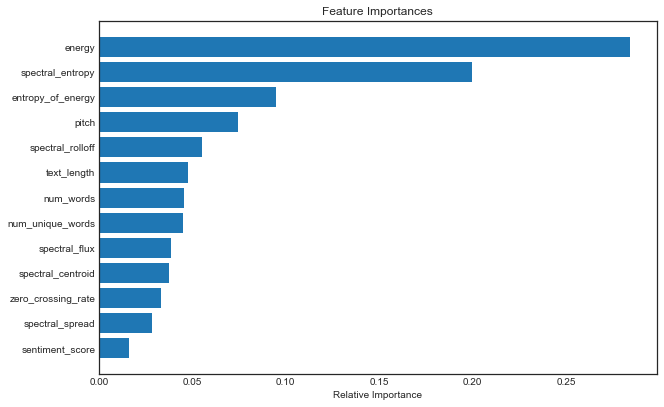

In [17]:
importances = clf.named_steps['clf'].feature_importances_

features = X_train.drop(['id','text'], axis=1).columns
indices = np.argsort(importances)

plt.figure(figsize=(10, len(features)/2))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Here I will perform a more detailed analysis of acoustic and textual features in order to assess their impact on the result of the classifier.

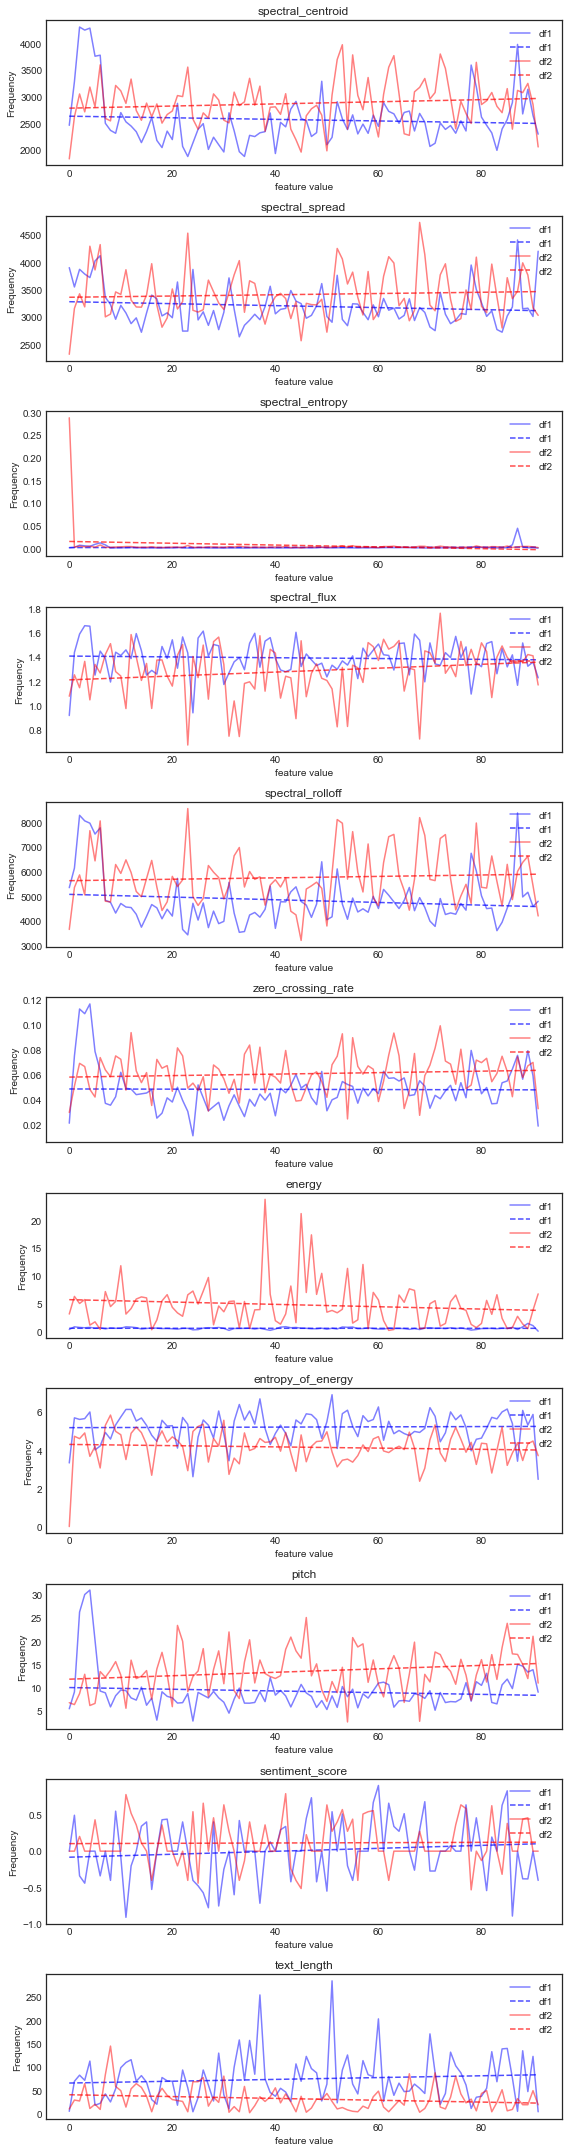

In [20]:

# features list
features = ['spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff',
            'zero_crossing_rate', 'energy', 'entropy_of_energy', 'pitch', 'sentiment_score','text_length']

# create a graph grid
fig, axs = plt.subplots(len(features), 1, figsize=(8, 30))
colors = ['blue', 'red']

# for each feature
for i, feature in enumerate(features):
    # display a feature histogram for each dataframe
    for j, df in enumerate([df1, df2]):
        axs[i].plot(df[feature], color=colors[j], alpha=0.5)

        # calculate linear regression coefficients
        x = np.arange(len(df[feature]))
        y = df[feature]
        coeffs = np.polyfit(x, y, 1)
        # adding trend line
        axs[i].plot(x, np.polyval(coeffs, x), color=colors[j], alpha=0.7, linestyle='--')

    # add title and axis labels
    axs[i].set_title(feature)
    axs[i].set_xlabel('feature value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend(['df1', 'df1','df2','df2'], loc='upper right')

plt.tight_layout()
plt.show()


Conclusions:

I converted 2 audio files into 2 datasets, trained a classification model based on text and acoustic features, the accuracy of which was 97%.

It will not be superfluous to recall that:

 - df1 - "Blue Carbuncle" by Arthur Conan Doyle (audiobook)
 - df2 - "Notting Hill" by Richard Curtis (audiobook)

I visualized the obtained signs, the analysis of the graphs is given below:

Spectral centroid - we can conclude that the df2 audio track contains higher frequency sounds. For example, this may be due to the presence of high-frequency instruments such as a violin or flute, or the presence of noise associated with electronics, or the speaker's voice has a higher frequency, which is most likely

The Spectral spread value reflects the spread of the signal spectrum in the wideband frequency range. If the Spectral spread is higher for one audio track than for another (as we see in df2), then this may indicate a wider frequency range.

Spectral entropy - Spectral entropy describes the complexity of the system: for example, speech will have a low value, while white noise will have a very high value. In our case, we have approximately the same audio tracks in terms of this indicator.

Spectral flux is a measure of how the spectral content of an audio signal changes over time. The higher the spectral flux, the greater the differences between the spectra of the audio signal at different time intervals, that is, the more changes occur in the spectral content of the sound throughout the sound track. This may indicate changes in sound texture or dynamics, such as new sound sources, changes in the intensity or timbre of sounds. In our case, df1 is more harmonious and stable over time with minimal changes in the spectral content of the sound.

Spectral rolloff is the frequency below which a certain percentage (up to 85%) of the energy of the signal spectrum is concentrated. If one audio track has a lower spectral rolloff (df1), then this means that most of the energy is concentrated at lower frequencies. This may indicate that the soundtrack has a low frequency character, for example, it may be a dull sound, low bass or a resonant sound (which confirms the conclusion about the spectral centroid)

Zero Crossing Rate (ZCR) is the number of times the sign of an audio signal changes from positive to negative or vice versa (sounds with a higher zero-crossing frequency (df2) tend to sound more "crackly" and more "hissing", noisier than sounds with lower zero-crossing frequency.)

Energy - volume level - apparently the sound of the df2 audio track is higher, the track itself has a more emotional character, and the central part of the work, apparently, is the most emotional and saturated in terms of volume. The df1 has a more monotonous sound.

Entropy of energy: Entropy of energy is a measure of the diversity of the energy values of a sound wave. Higher energy entropy (df2) may indicate a more complex and diverse signal, while lower entropy (df1) may indicate a simpler and more uniform signal. The indicator is stable over time.

Pitch - calculated as the frequency of the fundamental tone of the sound. When analyzing two audio files, this feature can show differences in melodies or intonations. For example, if one audio file contains singing and another speech, then they will have different fundamental frequencies. In my case, the pitch of the df2 audio track is higher and also tends to increase over time.

Sentiment score: overall score of the emotional coloring of the text, where a value close to 1 means positive, close to -1 - negative, close to 0 - neutral. In my case, both texts are close to neutral sentiment on average, however df1 has more expressions with negative sentiment.
 
Text length - text attribute, reflects the length of the text in characters. The author of df1 uses longer sentences.
